In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

roster = pd.read_csv("../resources/IST407-SP25-roster.csv")[["github_id","public_id"]]

## Participation Grades

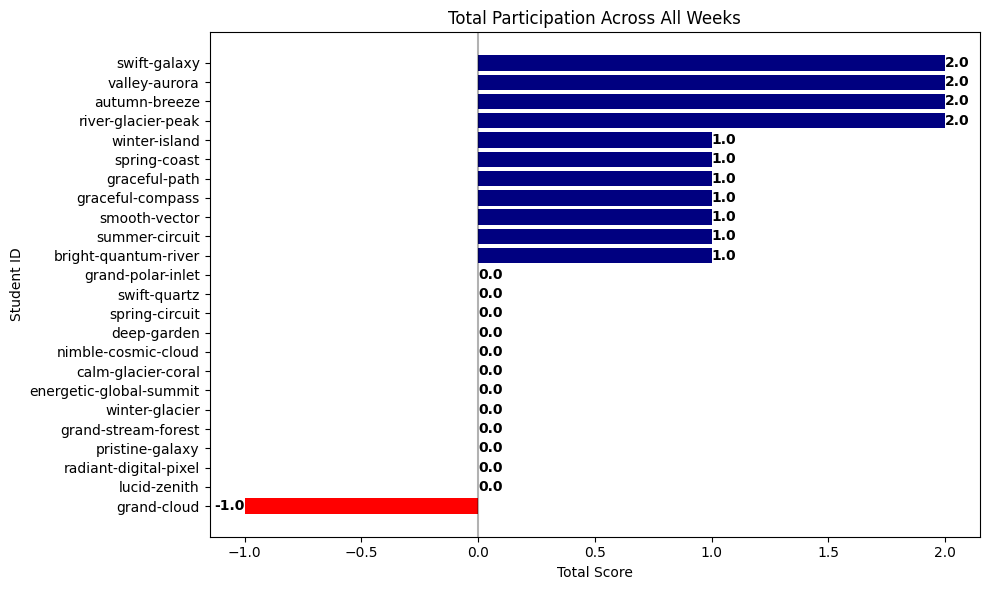

In [48]:
participation_grades = pd.read_csv("../resources/IST407-SP25 - Participation.csv")
week_columns = [col for col in participation_grades if col.startswith('Week')]
final_participation = participation_grades.merge(roster,on="github_id").drop("github_id",axis=1)
final_participation['total_score'] = final_participation[week_columns].sum(axis=1)
final_participation.sort_values('total_score',inplace=True)


plt.figure(figsize=(10,6))

# Create horizontal bars with different colors for positive/negative
colors = ['red' if x < 0 else 'navy' for x in final_participation['total_score']]
bars = plt.barh(final_participation['public_id'], final_participation['total_score'], color=colors)

# Add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add value labels at the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', 
             ha='left' if width >= 0 else 'right',
             va='center',
             fontweight='bold')

plt.title('Total Participation Across All Weeks')
plt.xlabel('Total Score')
plt.ylabel('Student ID')
plt.tight_layout()
plt.show()

## Weekly Exercise Grades

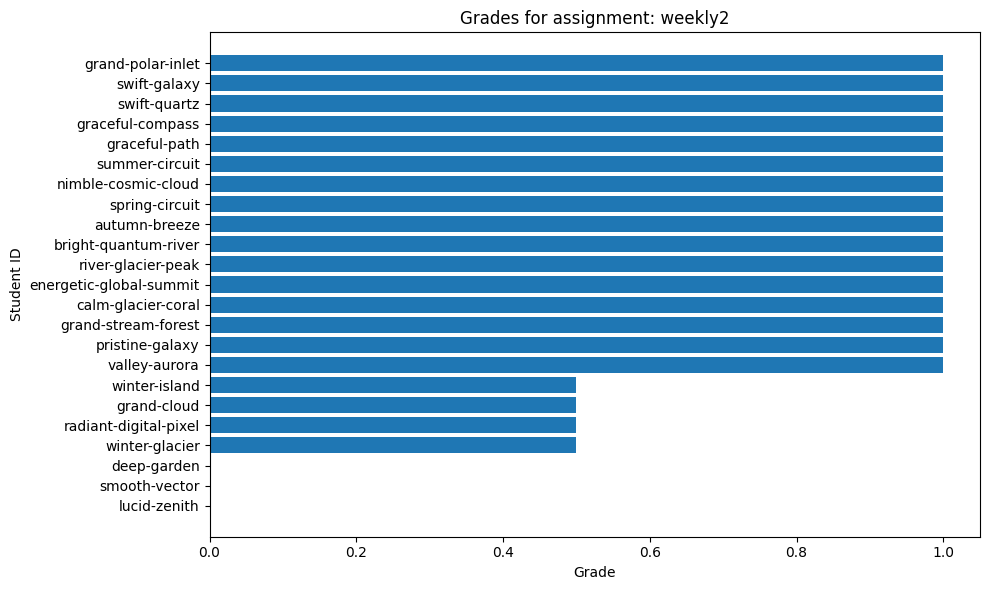

In [49]:
weekly_grades = pd.read_csv("../auto_grader/grades/SU-IST407-SP25/master/all_weekly_grades.csv")
final_weekly = weekly_grades.merge(roster,left_on="Student",right_on="github_id").drop(["Student","github_id"],axis=1)
for col in [x for x in grades.columns if x!="Student"]:
    df = final_weekly.sort_values(col)  # Changed to True for better readability
    plt.figure(figsize=(10,6))  # Added to make labels more readable
    plt.barh(df["public_id"], df[col])
    plt.title(f"Grades for assignment: {col}")
    plt.xlabel("Grade")
    plt.ylabel("Student ID")
    plt.tight_layout()  # Added to prevent label cutoff
    plt.show()


### Weekly grade summary

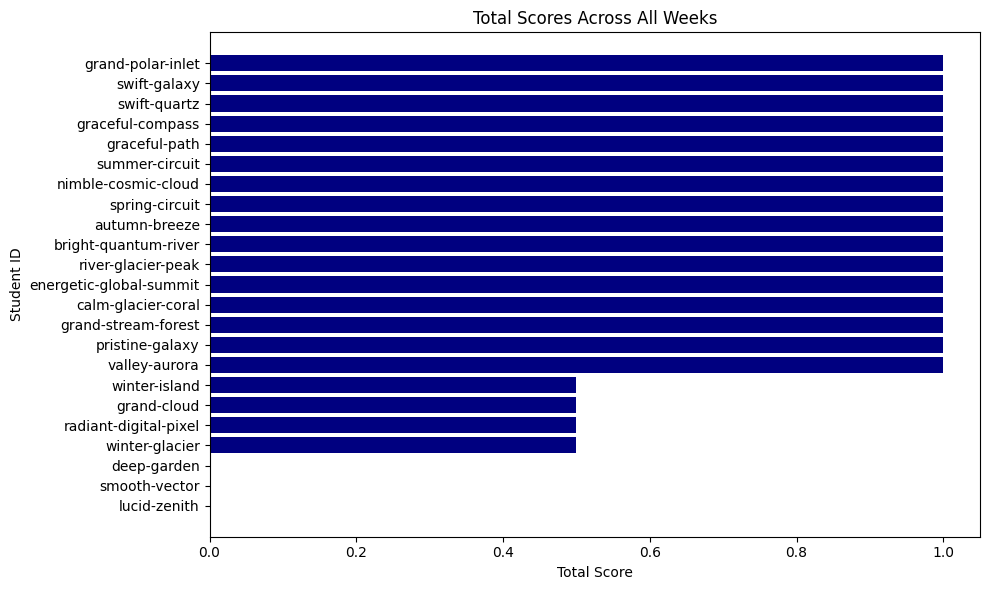

In [50]:
week_columns = [col for col in final_weekly.columns if col.startswith('weekly')]
final_weekly['total_score'] = final_weekly[week_columns].sum(axis=1)
final_weekly.sort_values('total_score',inplace=True)
plt.figure(figsize=(10,6))
plt.barh(final_weekly['public_id'], final_weekly['total_score'], color='navy')
plt.title('Total Scores Across All Weeks')
plt.xlabel('Total Score')
plt.ylabel('Student ID')
plt.tight_layout()
plt.show()

## Homework Grades

## Project Grades

## Overall Grades

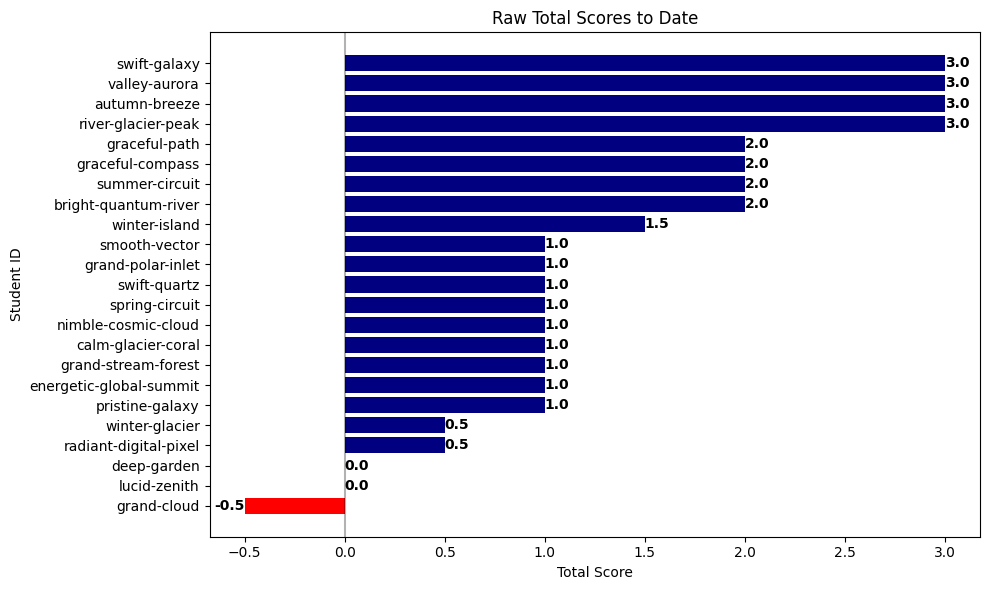

In [51]:
df_participation = final_participation[['public_id','total_score']]
df_weekly = final_weekly[['public_id','total_score']]
merged = df_participation.merge(df_weekly,on="public_id")

score_cols = [col for col in merged.columns if col.startswith("total_score")]
merged["final_score"] = merged[score_cols].sum(axis=1)
merged.sort_values('final_score',inplace=True)

plt.figure(figsize=(10,6))

# Create horizontal bars with different colors for positive/negative
colors = ['red' if x < 0 else 'navy' for x in merged['final_score']]
bars = plt.barh(merged['public_id'], merged['final_score'], color=colors)

# Add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add value labels at the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', 
             ha='left' if width >= 0 else 'right',
             va='center',
             fontweight='bold')

plt.title('Raw Total Scores to Date')
plt.xlabel('Total Score')
plt.ylabel('Student ID')
plt.tight_layout()
plt.show()